# CatBoostClasiffier

In [3]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [4]:
# Cargar los datos
df = pd.read_csv("../1_analisis/data_simp_preprocess_v2.csv")

Extraemos las etiquetas, descartamos las variables que carecen de valor predictivo (`id`) y las que están representadas como dummies. 

In [5]:
df_label = df["label"].astype(int)
df_label

0       1
1       0
2       0
3       1
4       0
       ..
8945    1
8946    1
8947    0
8948    1
8949    0
Name: label, Length: 8950, dtype: int64

In [6]:
drop_cols = ["id", "statement", "subject", "party_affiliation", "speaker","party_affiliation_uni"]

Para observar qué variables son éstas últimas, obtenemos las no binarias (booleans o numéricas con dos valores): 

In [7]:
# 1. Seleccionar columnas no booleanas ni binarias
non_binary_cols = []

# Columnas de tipo boolean o string
# bool_cols = df.select_dtypes("bool")
# num_cols = df.select_dtypes("number")

non_binary_cols += df.select_dtypes(exclude=['bool', 'number']).columns.tolist()

# Columnas numéricas que tienen más de 2 valores únicos (excluyendo label)
non_binary_cols += [
    col for col in df.select_dtypes(include='number').columns
    if df[col].nunique() > 2 and col != 'label'
]
non_binary_cols

['id',
 'statement',
 'subject',
 'speaker',
 'party_affiliation',
 'party_affiliation_uni',
 'party_affiliation_category_map',
 'speaker_job_grouped']

## Ingeniería de Características

Se ha añadido desde el preprocesado la variable `speaker_job_grouped` con la intención de sumarizar el impacto de la variable speaker_job, reducir cardinalidad del modelo y eliminar los dummies. Además, se contemplan las siguientes variables:

### Información no definida

In [8]:
# Crear variable: 1 si el trabajo o estado del speaker está no definido
df["has_non_define_info"] = (
    (df["speaker_job_non-define"] == 1) | 
    (df["state_info_non-define"] == 1)
).astype(int)

# Ver distribución y fake news rate
non_define_summary = df.groupby("has_non_define_info")["label"].agg(
    count="count", fake_news_rate="mean"
).reset_index()

non_define_summary


,has_non_define_info,count,fake_news_rate
0,0,5969,0.625900
1,1,2981,0.690708


### Speaker Job altamente o no asociado a Fake news

In [9]:
# 1. Seleccionar columnas de speaker_job
speaker_job_cols = [col for col in df.columns if col.startswith("speaker_job_")]

# 2. Calcular estadísticas por profesión
job_stats = {}
for col in speaker_job_cols:
    mask = df[col] == 1
    job_stats[col] = {
        "fake_news_rate": df[mask]["label"].mean(),
        "frequency": mask.sum(),
        "frequency_pct": mask.sum() / len(df)
    }

job_fake_df = pd.DataFrame.from_dict(job_stats, orient="index")

# 3. Definir umbrales
low_threshold = 0.65
high_threshold = 0.7
min_freq = 0.01

# 4. Seleccionar profesiones según riesgo
low_risk_jobs = job_fake_df[
    (job_fake_df["fake_news_rate"] < low_threshold) &
    (job_fake_df["frequency_pct"] > min_freq)
].index.tolist()

# 5. Crear columnas binarias
df["speaker_job_low_risk"] = df[low_risk_jobs].any(axis=1).astype(int)
drop_cols += low_risk_jobs

# Ver distribución y fake news rate
low_risk_job = df.groupby("speaker_job_low_risk")["label"].agg(
    count="count", fake_news_rate="mean"
).reset_index()

low_risk_job

,speaker_job_low_risk,count,fake_news_rate
0,0,4458,0.696501
1,1,4492,0.598842


### Topics asociados a fake news

In [10]:
# Seleccionar columnas que NO contienen guión bajo (no parecen dummies)
base_cols = [col for col in df.columns if "_" not in col]

# Crear nuevo DataFrame con solo esas columnas
df_base = df[base_cols]
df_base = df_base.drop(columns=["id", "statement", "subject", "speaker"])
# Ver columnas restantes
topic_cols = df_base.columns.tolist()

# Crear el nuevo DataFrame solo con esas columnas
topics_df = df[topic_cols].copy()

# Confirmar su forma
#topics_df = topics_df.drop(columns=["label"])
topics_df.head(5)

,label,economy,health-care,taxes,federal-budget,education,jobs,state-budget,candidates-biography,elections,...,oil-spill,afghanistan,wealth,china,florida,sexuality,water,population,animals,pensions
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Calcular fake_news_rate y frecuencia
topic_fake_data = {}
df_topic = topics_df.copy()
for col in topic_cols:
    mask = topics_df[col] == 1
    fake_news_rate = topics_df[mask]["label"].mean()
    frequency = mask.sum()
    frequency_pct = frequency / len(topics_df)
    topic_fake_data[col] = {
        "fake_news_rate": fake_news_rate,
        "frequency": frequency,
        "frequency_pct": frequency_pct
    }

topic_fake_df = pd.DataFrame.from_dict(topic_fake_data, orient="index")
topic_fake_df = topic_fake_df.sort_values(by="fake_news_rate", ascending=False)
# Quitar la fila 'label' si está incluida
topic_fake_df = topic_fake_df.drop(index="label", errors="ignore")
topic_fake_df

,fake_news_rate,frequency,frequency_pct
medicare,0.826087,161,0.017989
religion,0.812030,133,0.014860
congressional-rules,0.803922,51,0.005698
campaign-advertising,0.794118,68,0.007598
message-machine-2012,0.780702,228,0.025475
...,...,...,...
income,0.533333,150,0.016760
afghanistan,0.533333,45,0.005028
pensions,0.512821,39,0.004358
bipartisanship,0.500000,82,0.009162


In [12]:
# Definir umbrales
rate_threshold = 0.65
freq_threshold = 0.002

# Seleccionar temas de bajo riesgo
low_risk_topics = topic_fake_df[
    (topic_fake_df["fake_news_rate"] < rate_threshold) &
    (topic_fake_df["frequency_pct"] > freq_threshold)
].index.tolist()

# Crear la nueva columna binaria
df["has_low_risk_topic"] = df[low_risk_topics].any(axis=1).astype(int)


# Ver distribución y fake news rate
low_risk_top = df.groupby("has_low_risk_topic")["label"].agg(
    count="count", fake_news_rate="mean"
).reset_index()
low_risk_top

,has_low_risk_topic,count,fake_news_rate
0,0,3309,0.701420
1,1,5641,0.615848


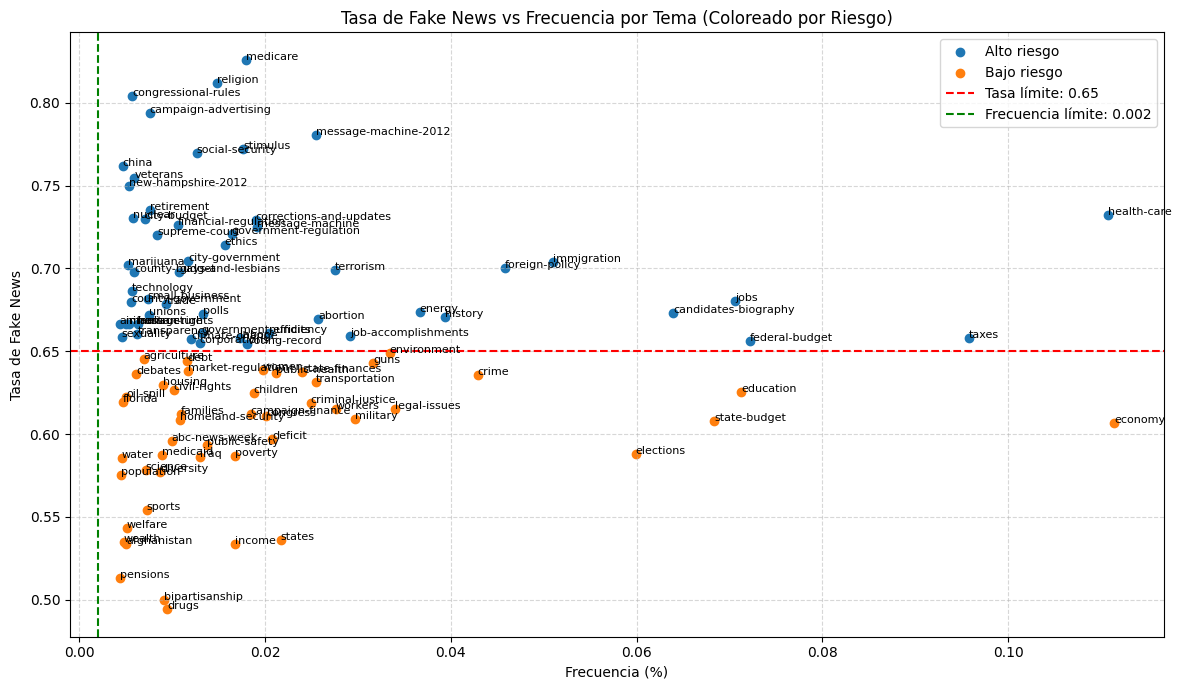

In [13]:
import matplotlib.pyplot as plt

# Clasificar los temas
def classify_topic(row):
    if row["fake_news_rate"] < rate_threshold and row["frequency_pct"] > freq_threshold:
        return "Bajo riesgo"
    else:
        return "Alto riesgo"

topic_fake_df["riesgo"] = topic_fake_df.apply(classify_topic, axis=1)

# Graficar
plt.figure(figsize=(12, 7))

for riesgo, subset in topic_fake_df.groupby("riesgo"):
    plt.scatter(subset["frequency_pct"], subset["fake_news_rate"], label=riesgo)

    for topic, row in subset.iterrows():
        plt.text(row["frequency_pct"], row["fake_news_rate"], topic, fontsize=8)

# Líneas de umbral
plt.axhline(rate_threshold, color='red', linestyle='--', label=f"Tasa límite: {rate_threshold}")
plt.axvline(freq_threshold, color='green', linestyle='--', label=f"Frecuencia límite: {freq_threshold}")

# Estilo
plt.title("Tasa de Fake News vs Frecuencia por Tema (Coloreado por Riesgo)")
plt.xlabel("Frecuencia (%)")
plt.ylabel("Tasa de Fake News")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [14]:
rate_threshold = 0.70
freq_threshold = 0.001
# Seleccionar temas de alto riesgo
high_risk_topics = topic_fake_df[
    (topic_fake_df["fake_news_rate"]> rate_threshold) & 
    (topic_fake_df["frequency_pct"] > freq_threshold)
].index.tolist()

# Crear la nueva columna binaria
df["has_high_risk_topic"] = df[high_risk_topics].any(axis=1).astype(int)
# Ver distribución y fake news rate
high_risk_top = df.groupby("has_high_risk_topic")["label"].agg(
    count="count", fake_news_rate="mean"
).reset_index()
high_risk_top

,has_high_risk_topic,count,fake_news_rate
0,0,5903,0.605455
1,1,3047,0.728914


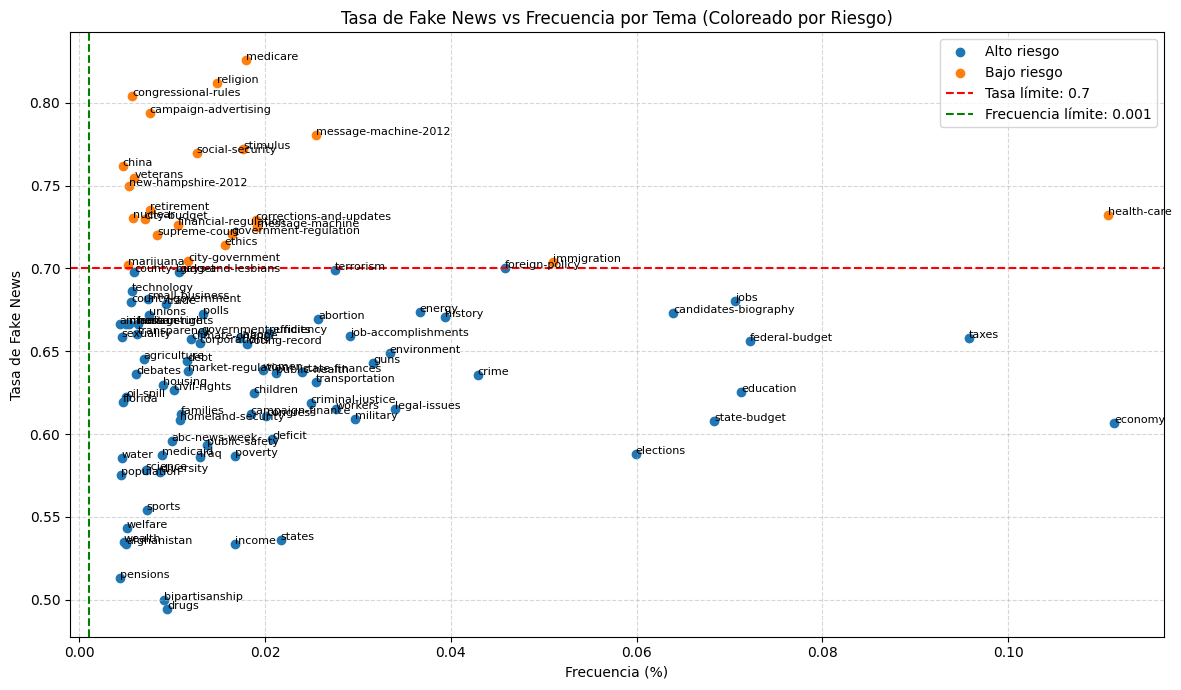

In [15]:
import matplotlib.pyplot as plt

# Clasificar los temas
def classify_topic(row):
    if row["fake_news_rate"] > rate_threshold and row["frequency_pct"] > freq_threshold:
        return "Bajo riesgo"
    else:
        return "Alto riesgo"

topic_fake_df["riesgo"] = topic_fake_df.apply(classify_topic, axis=1)

# Graficar
plt.figure(figsize=(12, 7))

for riesgo, subset in topic_fake_df.groupby("riesgo"):
    plt.scatter(subset["frequency_pct"], subset["fake_news_rate"], label=riesgo)

    for topic, row in subset.iterrows():
        plt.text(row["frequency_pct"], row["fake_news_rate"], topic, fontsize=8)

# Líneas de umbral
plt.axhline(rate_threshold, color='red', linestyle='--', label=f"Tasa límite: {rate_threshold}")
plt.axvline(freq_threshold, color='green', linestyle='--', label=f"Frecuencia límite: {freq_threshold}")

# Estilo
plt.title("Tasa de Fake News vs Frecuencia por Tema (Coloreado por Riesgo)")
plt.xlabel("Frecuencia (%)")
plt.ylabel("Tasa de Fake News")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [16]:
# Contar la distribución de clases
label_counts = df['label'].value_counts().sort_index()

# Imprimir distribución
print("Distribución de la clase objetivo:")
print(label_counts)
print("\nProporciones:")
print((label_counts / label_counts.sum()).round(3))

Distribución de la clase objetivo:
label
0.0    3155
1.0    5795
Name: count, dtype: int64

Proporciones:
label
0.0    0.353
1.0    0.647
Name: count, dtype: float64


El dataset está desbalanceado, por lo que se usará como primera aproximación en CatBoost el parámetro `auto_class_weights = 'Balanced' `

## Modelo CatBoost Simple

### Evaluación

In [17]:
# Definir la columna objetivo
X = df.copy().drop(columns=['label'])
X = X.drop(columns=drop_cols)
state_cols = [col for col in df.columns if col.startswith("state_info_")]
X = X.drop(columns=state_cols)
y = df_label

# Detectar columnas categóricas
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features

['party_affiliation_category_map', 'speaker_job_grouped']

In [18]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inicializar y entrenar el modelo
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.03,
    depth=8,
    cat_features=cat_features,
    auto_class_weights='Balanced',
    verbose=100,
    random_state=42
)
model.fit(X_train, y_train)

0:	learn: 0.6921611	total: 121ms	remaining: 1m
100:	learn: 0.6549678	total: 1.76s	remaining: 6.95s
200:	learn: 0.6392998	total: 3.13s	remaining: 4.66s
300:	learn: 0.6261771	total: 4.27s	remaining: 2.83s
400:	learn: 0.6070126	total: 5.67s	remaining: 1.4s
499:	learn: 0.5897605	total: 7.21s	remaining: 0us


In [19]:
# Evaluar el modelo
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5513966480446927
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.62      0.49       631
           1       0.71      0.52      0.60      1159

    accuracy                           0.55      1790
   macro avg       0.56      0.57      0.55      1790
weighted avg       0.61      0.55      0.56      1790



### Importancia de categorías

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener importancia
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Crear DataFrame ordenado
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las 20 más importantes
print(importance_df.head(20))

                            Feature  Importance
101             speaker_job_grouped   15.742649
0    party_affiliation_category_map   10.295365
129             has_high_risk_topic    7.788986
127            speaker_job_low_risk    4.842036
128              has_low_risk_topic    3.734067
6                              jobs    2.882127
3                             taxes    2.173119
1                           economy    2.057124
4                    federal-budget    2.043626
2                       health-care    2.008458
8              candidates-biography    2.002665
117          speaker_job_non-define    1.894999
126             has_non_define_info    1.826335
11                   foreign-policy    1.593479
13                          history    1.389730
118     speaker_job_president-elect    1.341508
27                           states    1.059520
5                         education    1.039816
45                         religion    0.981821
38                         medicare    0

## Ingenieria de categorías 

### Estados de bajo/alto riesgo

In [21]:
# 1. Filtrar columnas de estados
state_cols = [col for col in df.columns if col.startswith("state_info_")]

# 2. Calcular fake rate y frecuencia
state_stats = {}
for col in state_cols:
    mask = df[col] == 1
    state_stats[col] = {
        "fake_news_rate": df[mask]["label"].mean(),
        "frequency": mask.sum(),
        "frequency_pct": mask.sum() / len(df)
    }

# 3. Convertir a DataFrame
state_df = pd.DataFrame.from_dict(state_stats, orient="index")

# 4. Definir umbrales
low_fake_threshold = 0.8
min_freq_threshold = 0.01

# 5. Seleccionar estados de bajo riesgo
low_risk_states = state_df[
    (state_df["fake_news_rate"] < low_fake_threshold) &
    (state_df["frequency_pct"] > min_freq_threshold)
].index.tolist()

# 6. Crear variable binaria
df["state_low_risk"] = df[low_risk_states].any(axis=1).astype(int)

# 7. Verificación
print("Estados seleccionados como bajo riesgo:", low_risk_states)
print(df["state_low_risk"].value_counts())
print(df.groupby("state_low_risk")["label"].mean())

df = df.drop(columns=state_cols)

Estados seleccionados como bajo riesgo: ['state_info_arizona', 'state_info_california', 'state_info_florida', 'state_info_georgia', 'state_info_illinois', 'state_info_massachusetts', 'state_info_new jersey', 'state_info_new york', 'state_info_non-define', 'state_info_ohio', 'state_info_oregon', 'state_info_rhode island', 'state_info_texas', 'state_info_virginia', 'state_info_washington, d.c.', 'state_info_wisconsin']
state_low_risk
1    7833
0    1117
Name: count, dtype: int64
state_low_risk
0    0.643688
1    0.648028
Name: label, dtype: float64


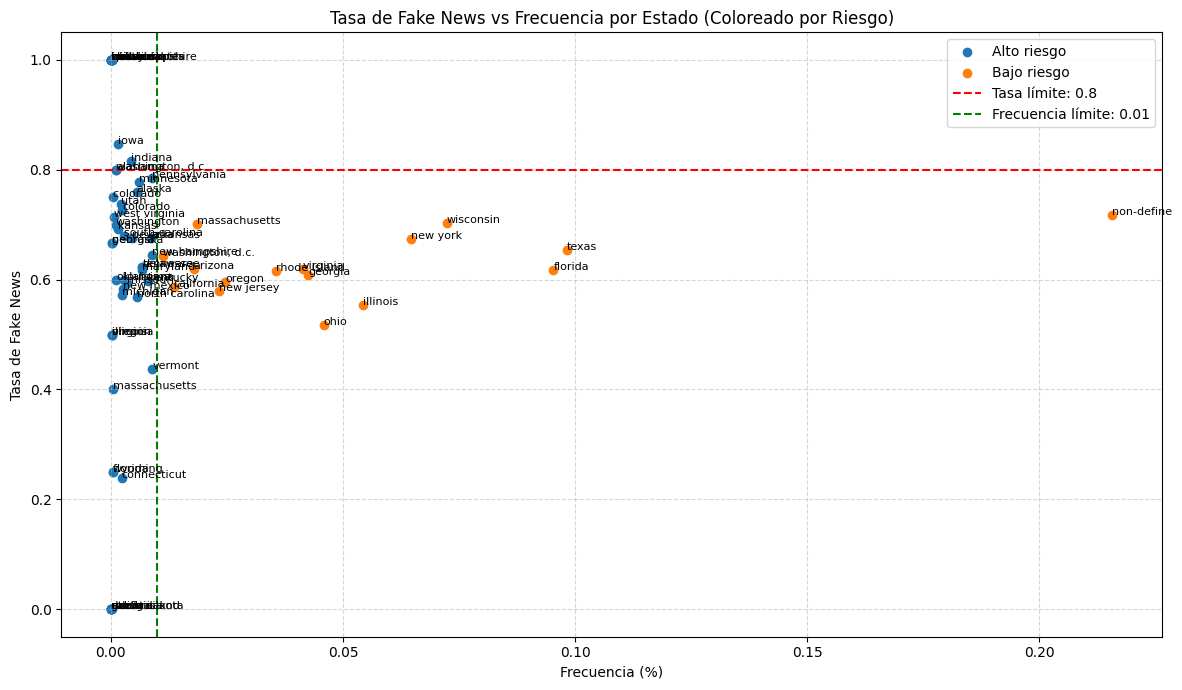

In [22]:
import matplotlib.pyplot as plt

# Clasificar estados según thresholds
def classify_state(row):
    if row["fake_news_rate"] < low_fake_threshold and row["frequency_pct"] > min_freq_threshold:
        return "Bajo riesgo"
    else:
        return "Alto riesgo"

state_df["riesgo"] = state_df.apply(classify_state, axis=1)

# Graficar
plt.figure(figsize=(12, 7))

for riesgo, subset in state_df.groupby("riesgo"):
    plt.scatter(subset["frequency_pct"], subset["fake_news_rate"], label=riesgo)

    for state, row in subset.iterrows():
        label = state.replace("state_info_", "")  # limpiar nombre
        plt.text(row["frequency_pct"], row["fake_news_rate"], label, fontsize=8)

# Líneas de umbral
plt.axhline(low_fake_threshold, color='red', linestyle='--', label=f"Tasa límite: {low_fake_threshold}")
plt.axvline(min_freq_threshold, color='green', linestyle='--', label=f"Frecuencia límite: {min_freq_threshold}")

# Estilo
plt.title("Tasa de Fake News vs Frecuencia por Estado (Coloreado por Riesgo)")
plt.xlabel("Frecuencia (%)")
plt.ylabel("Tasa de Fake News")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [23]:
df["low_risk"] = (
    (df["has_low_risk_topic"] == 1) | 
    (df["speaker_job_low_risk"] == 1)
).astype(int)

# Ver distribución y fake news rate
non_define_summary = df.groupby("low_risk")["label"].agg(
    count="count", fake_news_rate="mean"
).reset_index()

# Mostrar resumen
print("Distribución de has_non_define_info:")
print(df["low_risk"].value_counts())
print("\nFake rate por grupo:")
print(non_define_summary)

Distribución de has_non_define_info:
low_risk
1    7234
0    1716
Name: count, dtype: int64

Fake rate por grupo:
   low_risk  count  fake_news_rate
0         0   1716        0.747669
1         1   7234        0.623721


### Entrenamiento del modelo con la nueva variable

In [24]:
X.head(5)

,party_affiliation_category_map,economy,health-care,taxes,federal-budget,education,jobs,state-budget,candidates-biography,elections,...,speaker_job_social media posting,speaker_job_speaker of the house of representatives,speaker_job_u.s. congressman,speaker_job_u.s. house of representatives,"speaker_job_u.s. representative, florida district 23",speaker_job_u.s. senator from ohio,has_non_define_info,speaker_job_low_risk,has_low_risk_topic,has_high_risk_topic
0,political-affiliation,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,0,0,1,1
1,political-affiliation,0,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,0,1,0,1
2,political-affiliation,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,0,1,1,0
3,other-political-groups,0,0,0,0,0,0,0,1,0,...,False,False,False,False,False,False,1,0,1,1
4,political-affiliation,0,1,0,0,0,0,1,0,0,...,False,False,False,False,False,False,1,0,1,1


In [25]:
# Entrenamos el mismo modelo que antes
# Definir la columna objetivo
target = 'label'
topic_cols.append(target)
X = df.drop(columns=target)
y = df[target]

# Detectar columnas categóricas
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inicializar y entrenar el modelo
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    cat_features=cat_features,
    auto_class_weights='Balanced',
    verbose=100,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

0:	learn: 0.6893815	total: 13.5ms	remaining: 6.72s
100:	learn: 0.6239032	total: 1.41s	remaining: 5.59s
200:	learn: 0.5855345	total: 2.84s	remaining: 4.22s
300:	learn: 0.5550406	total: 4.6s	remaining: 3.04s
400:	learn: 0.5298330	total: 6.61s	remaining: 1.63s
499:	learn: 0.5043452	total: 8.64s	remaining: 0us
Accuracy: 0.5932960893854748
Classification Report:
               precision    recall  f1-score   support

         0.0       0.44      0.58      0.50       631
         1.0       0.72      0.60      0.66      1159

    accuracy                           0.59      1790
   macro avg       0.58      0.59      0.58      1790
weighted avg       0.62      0.59      0.60      1790



La puntuación sube respecto a iteraciones anteriores, pero no es el mejor resultado

In [26]:
# Obtener importancia
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Crear DataFrame ordenado
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las 20 más importantes
print(importance_df.head(50))

                            Feature  Importance
3                           speaker   13.461551
107             speaker_job_grouped   10.833682
2                           subject    9.552058
4                 party_affiliation    6.237490
5             party_affiliation_uni    5.279199
6    party_affiliation_category_map    3.762712
142             has_high_risk_topic    3.587269
141              has_low_risk_topic    1.847467
12                             jobs    1.561160
10                   federal-budget    1.058480
8                       health-care    1.039750
140            speaker_job_low_risk    1.020509
9                             taxes    0.978904
7                           economy    0.942208
44                         medicare    0.940416
33                           states    0.911918
143                  state_low_risk    0.894919
14             candidates-biography    0.880739
17                   foreign-policy    0.863932
144                        low_risk    0

F1 score macro avg ha bajado un 2% al usar el **top20** y se mantiene al usar el **top50**. Usar las 50 más im0portantes genera el mismo rendimiento, pero resta complejidad al modelo y reduce el tiempo de entrenamiento. Se procede a comenzar con tunning para ver hasta cuánto puede llegar el estimador empleado, mejorando sus hiperparámetros. Comenzamos con búsqueda aleatoria y un amplio rango de hiperparámetros. 

In [27]:
# Filtramos las más relevantes
top_n = 15
top_features = importance_df['Feature'].head(top_n).tolist()

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]
cat_features_top = X_train_top.select_dtypes(include=['object']).columns.tolist()
# Reentrenamos el modelo
model_top = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    cat_features=cat_features_top,
    auto_class_weights='Balanced',
    verbose=100,
    random_state=42
)
model_top.fit(X_train_top, y_train)

# Evaluar el modelo
y_pred_top = model_top.predict(X_test_top)
print("Accuracy:", accuracy_score(y_test, y_pred_top))
print("Classification Report:\n", classification_report(y_test, y_pred_top))

0:	learn: 0.6902667	total: 20.1ms	remaining: 20.1s
100:	learn: 0.6256105	total: 1.63s	remaining: 14.5s
200:	learn: 0.5896275	total: 3.86s	remaining: 15.4s
300:	learn: 0.5519300	total: 5.38s	remaining: 12.5s
400:	learn: 0.5218458	total: 6.86s	remaining: 10.2s
500:	learn: 0.4971726	total: 8.27s	remaining: 8.24s
600:	learn: 0.4759812	total: 9.71s	remaining: 6.44s
700:	learn: 0.4558148	total: 11.2s	remaining: 4.76s
800:	learn: 0.4372412	total: 12.6s	remaining: 3.13s
900:	learn: 0.4202873	total: 14s	remaining: 1.54s
999:	learn: 0.4060290	total: 15.4s	remaining: 0us
Accuracy: 0.5770949720670391
Classification Report:
               precision    recall  f1-score   support

         0.0       0.42      0.52      0.47       631
         1.0       0.70      0.61      0.65      1159

    accuracy                           0.58      1790
   macro avg       0.56      0.56      0.56      1790
weighted avg       0.60      0.58      0.59      1790



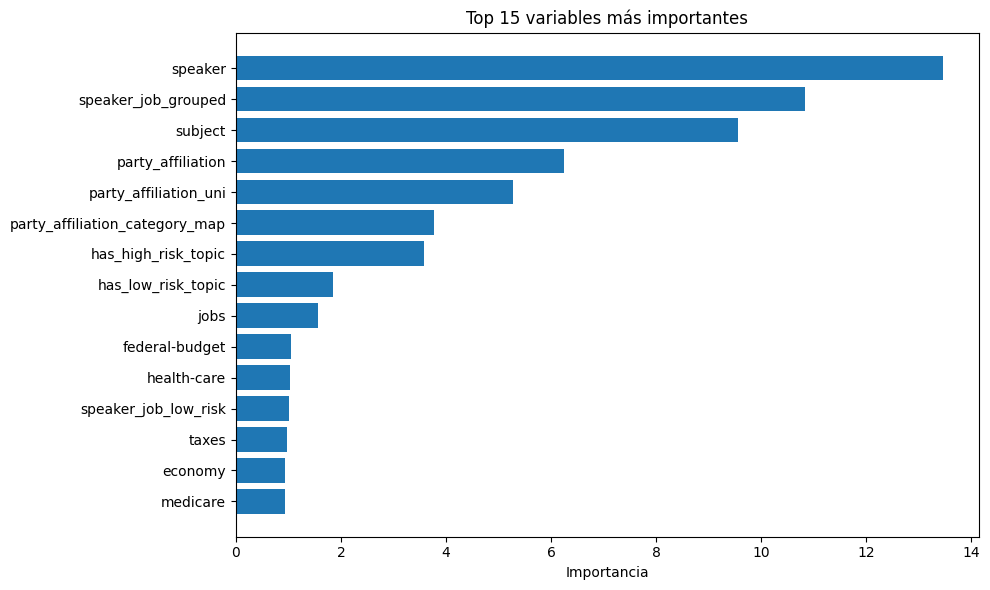

In [28]:
# Visualizar las top
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n][::-1], importance_df['Importance'][:top_n][::-1])
plt.xlabel('Importancia')
plt.title(f'Top {top_n} variables más importantes')
plt.tight_layout()
plt.show()

In [29]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Modelo base
base_model = CatBoostClassifier(
    auto_class_weights='Balanced',
    verbose=100,
    random_state=42
)

# Hiperparámetros a explorar
param_dist = {
    'iterations': [200, 500, 700],
    'learning_rate': [0.01, 0.03, 0.05],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5],
}

# Búsqueda aleatoria
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [30]:
# Iniciamos la busqueda
search.fit(X_train_top, y_train, cat_features=cat_features_top)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
0:	learn: 0.6926622	total: 35.2ms	remaining: 7.01s
100:	learn: 0.6677460	total: 1.43s	remaining: 1.4s
199:	learn: 0.6580386	total: 2.9s	remaining: 0us


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x131492b30>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'depth': [4, 6, 8],
                                        'iterations': [200, 500, 700],
                                        'l2_leaf_reg': [3, 5],
                                        'learning_rate': [0.01, 0.03, 0.05]},
                   scoring='f1_macro', verbose=2)

In [31]:
# Evaluación final en test
best_model = search.best_estimator_
y_pred = best_model.predict(X_test_top)
print("Best Params:", search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Params: {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 6}
Accuracy: 0.5798882681564246
Classification Report:
               precision    recall  f1-score   support

         0.0       0.44      0.69      0.54       631
         1.0       0.75      0.52      0.62      1159

    accuracy                           0.58      1790
   macro avg       0.60      0.60      0.58      1790
weighted avg       0.64      0.58      0.59      1790



El resultado baja un 1% conforme al primero obtenido. 

In [32]:

# Paso 1: Obtener probabilidades del modelo entrenado
y_probs = best_model.predict_proba(X_test_top)[:, 1]  # Clase 1

# Paso 2: Buscar el mejor umbral
thresholds = np.arange(0.1, 0.91, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_probs >= t).astype(int)
    score = f1_score(y_test, y_pred_thresh, average='macro')
    f1_scores.append(score)

# Paso 3: Obtener mejor umbral
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

# Paso 4: Evaluar con el umbral óptimo
y_pred_opt = (y_probs >= best_threshold).astype(int)

print(f"🔎 Mejor umbral: {best_threshold:.2f} con F1 macro: {best_f1:.4f}")
print("Best Params:", search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_opt))
print("Classification Report:\n", classification_report(y_test, y_pred_opt))

NameError: name 'np' is not defined

In [ ]:
# Dividir internamente para validación del early stopping
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train_top, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [ ]:
from catboost import Pool

# Pools de CatBoost para usar eval_set
train_pool = Pool(X_train_main, y_train_main, cat_features=cat_features_top)
val_pool = Pool(X_val, y_val, cat_features=cat_features_top)


In [ ]:
# Tomar los mejores hiperparámetros encontrados
best_params = search.best_params_
best_params.update({
    'auto_class_weights': 'Balanced',
    'early_stopping_rounds': 50,
    'verbose': 100,
    'random_state': 42
})

# Entrenar modelo final
final_model = CatBoostClassifier(**best_params)
final_model.fit(train_pool, eval_set=val_pool)

# Evaluar en conjunto de test final
y_pred_final = final_model.predict(X_test_top)
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Classification Report:\n", classification_report(y_test, y_pred_final))

Resultado óptimo: **58%**

# Generar CSV de resultados con el modelo final

In [ ]:
# Cargar los datos de test
df_test = pd.read_csv("../../data/processed/test_simp_preprocess_v1.csv")
df_test.columns.size

In [ ]:
import datetime
import pandas as pd
from catboost import Pool

# === 1. Guardar los IDs y limpiar
test_ids = df_test["id"]
df_test = df_test.drop(columns=["id"], errors="ignore")

# === 2. Asegurar que test tenga todas las columnas necesarias
missing_cols = set(top_features) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0  # Rellenar columnas faltantes con 0

# Avisar si faltan columnas por transparencia
if missing_cols:
    print(f"Columnas faltantes añadidas en test: {missing_cols}")

In [ ]:
# === 4. Seleccionar solo las columnas válidas y en el orden correcto
#df_test = df_test.drop(columns=drop_cols)
top_features_valid = [col for col in top_features if col in df_test.columns]
df_test = df_test[top_features_valid]

# === 5. Detectar columnas categóricas por nombre e índice
cat_feature_names = [col for col in cat_features_top if col in df_test.columns]
cat_feature_indices = [df_test.columns.get_loc(col) for col in cat_feature_names]

# === 6. Crear Pool y predecir
test_pool = Pool(df_test, cat_features=cat_feature_indices)
y_pred_test = final_model.predict(test_pool)

# === 7. Guardar predicciones
current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output = pd.DataFrame({
    "id": test_ids,
    "label": y_pred_test.astype(int)
})
filename = f"../3_summision/CatBoost_simp_{current_date}.csv"
output.to_csv(filename, index=False)
print(f"Predicciones guardadas en {filename}")

In [ ]:

# has_high_risk_topic
df_test["has_high_risk_topic"] = df_test[high_risk_topics].any(axis=1).astype(int)

# state_low_risk
df_test["state_low_risk"] = df_test[low_risk_states].any(axis=1).astype(int)

# speaker_job_low_risk
df_test["speaker_job_low_risk"] = df_test[low_risk_jobs].any(axis=1).astype(int)

# has_non_define_info
df_test["has_non_define_info"] = (
    (df_test.get("speaker_job_non-define", 0) == 1) |
    (df_test.get("state_info_non-define", 0) == 1)
).astype(int)

0:	learn: 0.6911446	total: 144ms	remaining: 1m 40s
100:	learn: 0.6400438	total: 2.95s	remaining: 17.5s
200:	learn: 0.6191385	total: 4.79s	remaining: 11.9s
300:	learn: 0.5958686	total: 8.63s	remaining: 11.4s
400:	learn: 0.5755530	total: 10.4s	remaining: 7.74s
500:	learn: 0.5587347	total: 12.9s	remaining: 5.11s
600:	learn: 0.5420220	total: 15s	remaining: 2.48s
699:	learn: 0.5281333	total: 18.3s	remaining: 0us
[CV] END depth=6, iterations=700, l2_leaf_reg=5, learning_rate=0.05; total time=  19.2s
0:	learn: 0.6927381	total: 22.8ms	remaining: 11.4s
100:	learn: 0.6578975	total: 3.37s	remaining: 13.3s
200:	learn: 0.6399284	total: 6.26s	remaining: 9.32s
300:	learn: 0.6277158	total: 10.5s	remaining: 6.97s
400:	learn: 0.6171914	total: 14.4s	remaining: 3.54s
499:	learn: 0.6085394	total: 17.6s	remaining: 0us
[CV] END depth=8, iterations=500, l2_leaf_reg=3, learning_rate=0.01; total time=  18.1s
0:	learn: 0.6911446	total: 12.4ms	remaining: 6.2s
100:	learn: 0.6400438	total: 2.06s	remaining: 8.15s
20